In [69]:
!pwd

/home/dileep/Desktop/python


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [206]:
txt = pd.read_csv('with_med.csv')
com = txt[['Text', 'Unnamed: 35']]
com['merge'] = com[['Text', 'Unnamed: 35']].apply(lambda x: ''.join(x), axis=1)
text = com['merge']
med = com['Unnamed: 35']

/home/dileep/anaconda3/envs/cpcv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [192]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dileep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [179]:
# Tokenizing text
text = text.values
text = text.tolist()
pattern = '[A-Za-z0-9]+(?=\\s+)'
text_tokenized = [regexp_tokenize(t.lower(), pattern) for t in text]

In [167]:
# Processing tokenized text

# Removing numerics and symbols
for i in range(len(text_tokenized)):
    text_tokenized[i] = [t for t in text_tokenized[i] if t.isalpha()]
    
# Removing stop words
english_stops = set(stopwords.words('english'))
for i in range(len(text_tokenized)):
    text_tokenized[i] = [t for t in text_tokenized[i] if t not in english_stops]

# Lemmatizing words
wordnet_lemmatizer = WordNetLemmatizer()
for i in range(len(text_tokenized)):
    text_tokenized[i] = [wordnet_lemmatizer.lemmatize(t) for t in text_tokenized[i]]


In [168]:
# Creating dictionary
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(text_tokenized)

# Creating corpus of (word_id,word_count) from dictionary
corpus = [dictionary.doc2bow(text) for text in text_tokenized]

In [169]:
from gensim.models.tfidfmodel import TfidfModel

# Creating a TF-IDF weighted list of words from the model
tfidf = TfidfModel(corpus)
nlp = [[] for i in range(len(corpus))]

for i in range(len(corpus)):
    tfidf_weights = tfidf[corpus[i]]
    sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
    for term_id, weight in sorted_tfidf_weights[:10]:
        nlp[i].append(dictionary.get(term_id))

In [170]:
from pandas import DataFrame

# Changing the list of lists inot a dataframe
nlp = DataFrame.from_records(nlp)

nlp.shape

(2196, 10)

In [171]:
nlp.to_csv('NLP.csv', index=False)

## Clustering using med and text

In [251]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import re

def remove_noise(text, stop_words = []):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.1, max_features=20000, tokenizer=remove_noise)

tfidf_matrix = tfidf_vectorizer.fit_transform(text)

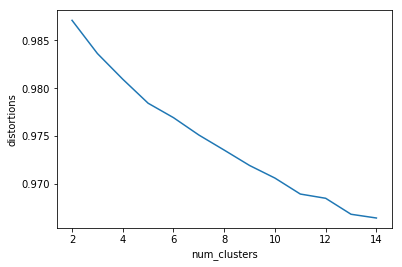

In [234]:
# Creating elbow plot
distortions = []
num_clusters = range(2,15)
for i in num_clusters:
    centroids, distortion = kmeans(tfidf_matrix.todense(), i)
    distortions.append(distortion)

# Plotting
elbow_plot_data = pd.DataFrame({'num_clusters': num_clusters, 
                                'distortions': distortions})
import seaborn as sns
sns.lineplot(x='num_clusters', y='distortions', data=elbow_plot_data)

In [252]:
from scipy.cluster.vq import kmeans, vq

num_clusters = 15

cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:30])

['injury', 'fall', 'alleged', 'fracture', 'bike', 'sustained', 'fast', 'wound', 'over', 'tetanus', 'toxoid', 'injuries', 'loc', 'report', 'xray', 'scalp', 'bleed', 'shoulder', 'ear', 'scan', 'lacerated', 'ortho', 'mannitol', 'leg', 'forehead', 'sutured', 'opinion', 'observation', 'multiple', 'sah']
['mannitol', 'antiedema', 'saline', 'measures', 'bleed', 'fall', 'neuromonitoring', 'weakness', 'labetalol', 'shift', 'edema', 'keep', 'sah', 'opinion', 'midline', 'temporal', 'sided', 'neurosurgery', 'intubation', 'sdh', 'sbp', 'side', 'mass', 'extension', 'perilesional', 'intraventricular', 'frontal', 'loc', 'close', 'bike']
['surgeons', 'situ', 'dc', 'flap', 'resection', 'buccal', 'mucosa', 'colon', 'tube', 'exploratory', 'unsupported', 'feeding', 'tpiece', 'saturating', 'laprotomy', 'cefoperazonesulbactam', 'awake', 'sating', 'surgery', 'cefoperazone', 'okay', 'foley', 'doses', 'stomach', 'overnight', 'mask', 'cefuroxime', 'wle', 'plan', 'sc']
['aspirin', 'clopidogrel', 'speech', 'atorva

In [273]:
words_df = pd.DataFrame(tfidf_matrix.todense())

In [275]:
words_df['label'], _ = vq(words_df, cluster_centers)

In [294]:
labels = words_df['label']

In [296]:
pd.DataFrame(labels).to_csv('labels.csv')

## Clustering using med

In [237]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import re

def remove_noise(text, stop_words = []):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=50, tokenizer=remove_noise)

tfidf_matrix = tfidf_vectorizer.fit_transform(med)

In [242]:
from scipy.cluster.vq import kmeans, vq

num_clusters = 5

cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:20])

['pantoprazole', 'ondansetron', 'paracetamol', 'ceftriaxone', 'tramadol', 'metronidazole', 'acid', 'clavulanic', 'diclofenac', 'amoxicillin', 'tetanus', 'day', 'toxoid', 'sulbactam', 'cefuroxime', 'dexamethasone', 'cefoperazone', 'amikacin', 'cefoperazonesulbactam', 'tazobactam']
['levetiracetam', 'mannitol', 'ondansetron', 'pantoprazole', 'ceftriaxone', 'saline', 'paracetamol', 'citicoline', 'cefuroxime', 'day', 'dexamethasone', 'diclofenac', 'amlodipine', 'labetalol', 'tetanus', 'tramadol', 'tazobactam', 'sulbactam', 'toxoid', 'chloride']
['day', 'pantoprazole', 'budesonide', 'tazobactam', 'piperacillin', 'paracetamol', 'potassium', 'bromide', 'chloride', 'ceftriaxone', 'ipratropium', 'ondansetron', 'levosalbutamol', 'noradrenaline', 'salbutamol', 'sodium', 'amlodipine', 'azithromycin', 'saline', 'tramadol']
['sulbactam', 'ranitidine', 'ceftriaxone', 'diclofenac', 'tramadol', 'metronidazole', 'day', 'paracetamol', 'pantoprazole', 'sodium', 'amikacin', 'labetalol', 'cefoperazonesulbac